# Visualisation
We use the [netgraph](https://github.com/paulbrodersen/netgraph) library along with [matplotlib](https://matplotlib.org) to visualise graphs.
First, we set up some data. If you are unfamiliar with that part, view the [Sample notebook](./Sample.ipynb) first

In [1]:
%reload_ext typedb_jupyter

In [2]:
%typedb connect open core 127.0.0.1:1729 admin password

Opened connection to: 127.0.0.1:1729


In [3]:
%typedb database recreate typedb_jupyter_graphs

Recreated database  typedb_jupyter_graphs


In [4]:
%typedb transaction open typedb_jupyter_graphs schema

Opened schema transaction on database 'typedb_jupyter_graphs'  


In [5]:
%%typeql

define 
attribute name, value string;
entity person, owns name @card(0..), plays friendship:friend;
relation friendship, relates friend @card(0..);

Query completed successfully! (No results to show)


'Stored result in variable: _typeql_result'

In [6]:
%typedb transaction commit

Transaction committed


In [7]:
%typedb transaction open typedb_jupyter_graphs write

Opened write transaction on database 'typedb_jupyter_graphs'  


In [8]:
%%typeql

insert 
$p1 isa person, has name "John";
$p2 isa person, has name "James";
$p3 isa person, has name "James", has name "Jimmy";
$f12 isa friendship, links (friend: $p1, friend: $p2);
$f23 isa friendship, links (friend: $p2, friend: $p3);

Query returned 1 rows.


f12,f23,p1,p2,p3
Relation(friendship: 0x1f00000000000000000000),Relation(friendship: 0x1f00000000000000000001),Entity(person: 0x1e00000000000000000000),Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)


'Stored result in variable: _typeql_result'

In [9]:
%typedb transaction commit

Transaction committed


# Visualisation

### Intialise matplotlib
Initialise matplotlib first. The `widget` mode allows interactive graphs inline.

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt

### Read some data

In [11]:
%typedb transaction open typedb_jupyter_graphs read

Opened read transaction on database 'typedb_jupyter_graphs'  


In [12]:
%%typeql
match $p isa person, has name $n;

Query returned 4 rows.


n,p
"Attribute(name: ""John"")",Entity(person: 0x1e00000000000000000000)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000001)
"Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002)
"Attribute(name: ""Jimmy"")",Entity(person: 0x1e00000000000000000002)


'Stored result in variable: _typeql_result'

In [13]:
%typedb transaction close

Transaction closed


### Create a graph from this data
Sadly, the basic TypeDB answers do not hold any information about the query structure. Till it does, we use a simple parser to parse out the structure from the query and reconstruct the graph.

In [14]:
from typedb_jupyter.utils.parser import TypeQLVisitor
from typedb_jupyter.graph.query import QueryGraph

parsed = TypeQLVisitor.parse_and_visit("match $p isa person, has name $n;")
query_graph = QueryGraph(parsed)

In [15]:
# Combine the data & the parsed query structure into the data-graph
from typedb_jupyter.graph.answer import AnswerGraphBuilder

answer_graph = AnswerGraphBuilder.build(query_graph, _typeql_result)
print("\n".join(map(str,answer_graph.edges))) # We now have a list of edges

Entity(person: 0x1e00000000000000000000)--[has]-->Attribute(name: "John")
Entity(person: 0x1e00000000000000000001)--[has]-->Attribute(name: "James")
Entity(person: 0x1e00000000000000000002)--[has]-->Attribute(name: "James")
Entity(person: 0x1e00000000000000000002)--[has]-->Attribute(name: "Jimmy")


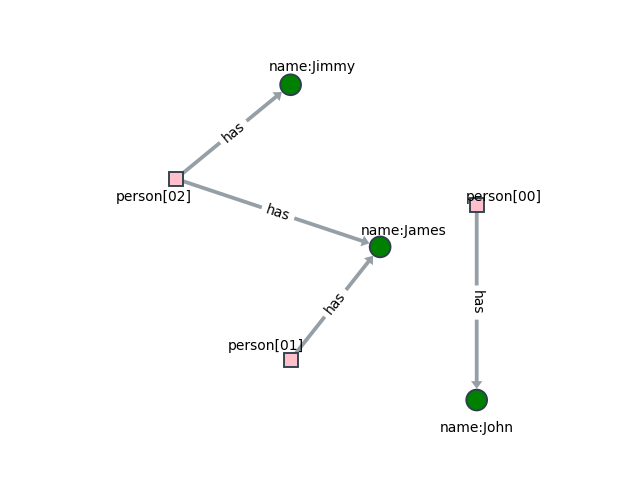

In [16]:
# The AnswerGraph plot method will plot onto the matplotlib plot. 
plt.figure() # For cleanliness, we'll tell matplotlib to create a new "figure" each time
plot_instance_1 = answer_graph.plot() # Limitations of netgraph require that you hold on to the returned value

## Some more examples

In [17]:
%typedb transaction open typedb_jupyter_graphs read

Opened read transaction on database 'typedb_jupyter_graphs'  


In [18]:
%%typeql
match
$f isa friendship, links ($friend: $p1, $friend: $p2);
$p1 has name $n1;
$p2 has name $n2;

Query returned 6 rows.


f,friend,n1,n2,p1,p2
Relation(friendship: 0x1f00000000000000000000),RoleType(friendship:friend),"Attribute(name: ""John"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000000),Entity(person: 0x1e00000000000000000001)
Relation(friendship: 0x1f00000000000000000000),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""John"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000000)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""Jimmy"")",Entity(person: 0x1e00000000000000000001),Entity(person: 0x1e00000000000000000002)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""James"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002),Entity(person: 0x1e00000000000000000001)
Relation(friendship: 0x1f00000000000000000001),RoleType(friendship:friend),"Attribute(name: ""Jimmy"")","Attribute(name: ""James"")",Entity(person: 0x1e00000000000000000002),Entity(person: 0x1e00000000000000000001)


'Stored result in variable: _typeql_result'

In [19]:
%typedb transaction close

Transaction closed


/Users/krishnangovindraj/code/side/typedb-jupyter/src/.venv/lib/python3.11/site-packages/netgraph/_parser.py:23: UserWarning: Multi-graphs are not properly supported. Duplicate edges are plotted as a single edge; edge weights (if any) are summed.
  warnings.warn(msg)


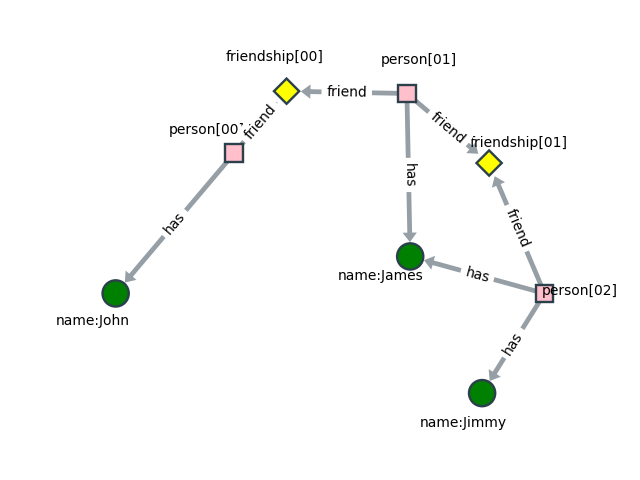

In [20]:
%matplotlib widget
from typedb_jupyter.graph.query import QueryGraph
from typedb_jupyter.graph.answer import AnswerGraphBuilder

# Our mini-parser doesn't support roles yet
parsed = TypeQLVisitor.parse_and_visit("""match
$f isa friendship, links ($friend: $p1, $friend: $p2);
$p1 has name $n1;
$p2 has name $n2;
""")
query_graph = QueryGraph(parsed)
answer_graph = AnswerGraphBuilder.build(query_graph, _typeql_result)
plt.figure()
plot_instance_2 = answer_graph.plot() # We use a different name to avoid clobbering the earlier visualisation